**Chapter 4 – Training Linear Models**

# Exercise solutions

## 12. Batch Gradient Descent with early stopping for Softmax Regression
(without using Scikit-Learn)

- This works for 2 or more classes  
- early stopping never actually happens with this data set, because it doesn't ever overfit
- if you run this with just two classes, it will still calculate two classifiers. A little inefficient, but it doesn't matter for now  
- I found that the best alpha changes greatly based on the randomness of my train/test split!
- train/test split also changes the boundaries that are learned

In [107]:
# Load data
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]
y_dos = (iris["target"] != 0).astype(np.int)

X_train, X_test, y_train, y_test, y_dos_train, y_dos_test = \
    train_test_split(X, y, y_dos, train_size=.8, random_state=2)

In [108]:
# def logistic_predict(X, theta):
#     z = X.dot(theta)
#     g = 1.0/(1+np.exp(-z))
#     return g


def softmax(X, theta):
    score = X.dot(theta)
    exp_score = np.exp(score)
    sums = exp_score.sum(axis=1, keepdims=True)
    return exp_score/sums


def create_ovr_matrix(y):
    """
    Create one-vs-rest matrix for y labels
    """
    y_ovr = []
    classes = np.unique(y)
    for class_ in classes:
        y_ovr.append((y == class_).astype(int))
    return np.column_stack(y_ovr)


def compute_log_loss(y, p):
    total_loss = y*np.log(p) # y's that are equal to 0 (non-target classes) will have 0 as their product
    J = -(total_loss.mean())
    return J


def compute_gradients(X, y, theta, p=None):
    m = X.shape[0]
    if p is None:
        p = softmax(X, theta)
    gradients = (X.T).dot(p-y)/m
    return gradients


def update_parameters(theta, gradients, alpha):
    theta_new = theta - alpha*gradients
    return theta_new


def get_preds(p):
    """
    p: n_obs by n_classifiers matrix of probability predictions
    returns: the most probable prediction from each classifier
    """
    pred_ix = np.argmax(p, axis=1)
    preds = p[np.arange(p.shape[0]), pred_ix]
    return preds



In [109]:
def main(X_train, X_test, y_train, y_test):
    # Add bias term
    X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]
    n_features = X_train.shape[1]
    n_classes = np.unique(y_train).shape[0]
    y_train_ovr = create_ovr_matrix(y_train)
    y_test_ovr = create_ovr_matrix(y_test)
    # Randomly initialize parameters
    thetas = np.random.rand(n_features, n_classes)
    prev_test_cost = None
    alpha = .01
    n_steps = 0
    test_cost_list = []
    # Train model until Test cost is higher than it was in the previous iteration
    while True:
        p_train = softmax(X_train, thetas)
        p_test = softmax(X_test, thetas)
        train_cost = compute_log_loss(y_train_ovr, p_train)
        test_cost = compute_log_loss(y_test_ovr, p_test)
        test_cost_list.append(test_cost)
        print 'Train cost:', train_cost
        print 'Test cost:', test_cost
        if prev_test_cost and test_cost > prev_test_cost:
            break
        prev_test_cost = test_cost
        gradients = compute_gradients(X_train, y_train_ovr, thetas, p_train)
        thetas = update_parameters(thetas, gradients, alpha)
        n_steps += 1
        if n_steps > 10000: # Just in case we train for too long
            break
    train_accuracy = accuracy_score(y_train, np.argmax(p_train, axis=1))
    test_accuracy = accuracy_score(y_test, np.argmax(p_test, axis=1))
    print 'Number of steps:', n_steps
    print 'Parameters:', thetas
    print 'Train cost:', train_cost
    print 'Test cost:', test_cost
    print 'Train accuracy:', train_accuracy
    print 'Test accuracy:', test_accuracy
    return test_cost_list, thetas
    
    

In [110]:
tcl, thetas = main(X_train, X_test, y_train, y_test)

Train cost: 0.681179988007
Test cost: 0.759052768806
Train cost: 0.656674798052
Test cost: 0.730338301364
Train cost: 0.632936086099
Test cost: 0.702450055503
Train cost: 0.61002082104
Test cost: 0.675452760159
Train cost: 0.587985853645
Test cost: 0.649411756718
Train cost: 0.566886611205
Test cost: 0.624391627061
Train cost: 0.546775592889
Test cost: 0.600454575467
Train cost: 0.527700709972
Test cost: 0.577658603376
Train cost: 0.509703538844
Test cost: 0.556055542965
Train cost: 0.492817578174
Test cost: 0.535689043691
Train cost: 0.477066621771
Test cost: 0.516592631986
Train cost: 0.46246337156
Test cost: 0.498787983834
Train cost: 0.449008416488
Test cost: 0.482283557719
Train cost: 0.436689689245
Test cost: 0.467073726453
Train cost: 0.425482481655
Test cost: 0.453138517305
Train cost: 0.415350052722
Test cost: 0.440444020932
Train cost: 0.406244805984
Test cost: 0.428943465817
Train cost: 0.398109954002
Test cost: 0.418578885927
Train cost: 0.390881538086
Test cost: 0.40928324

In [67]:
import matplotlib.pyplot as plt

%matplotlib inline

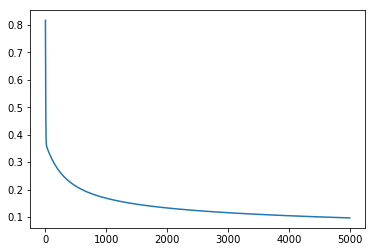

In [89]:
# Plot test cost after each iteration
plt.plot(tcl)

[0, 7, 0, 3.5]

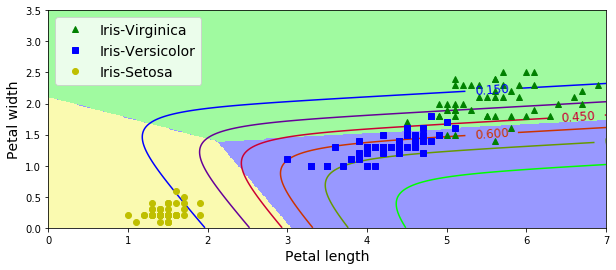

In [111]:
# Grab the plotting code from the author and plot my boundaries

x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

Y_proba = softmax(X_new_with_bias, thetas)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap, linewidth=5)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])